In [13]:
import os
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors
import csv

root = '/home/pawel/Magisterka/distributed_simulator'
simulation = 'evacuation'
grids_dir = f"{root}/examples/{simulation}/lib/grid_iterations"
config_path = f"{root}/examples/{simulation}/config/animation_config.csv"

## Create frames from files

In [3]:
"""each file is expected to contain numbers separated by space:
 - first 2 numbers are x and y dimension, respectively
 - next are x * y * 9, where each consecutive 9 numbers describe state of single cell (object and directions) """

def read_workers(grids_dir, verbose=False):
    """ reads grids from all the workers and converts them to frames.
    returns: map(worker_loc => frames)"""
    workers = {}
    for worker_dir in os.listdir(grids_dir):
        worker_dir_path = os.path.join(grids_dir, worker_dir)
        (x, y) = [int(c) for c in worker_dir.split("_")]
        if verbose:
            print(f"processing worker {(x, y)}")
        workers[(x,y)] = create_frames(worker_dir_path)
    return workers
        
def create_frames(worker_dir, verbose=False):
    """ converts grids saved in given directory to matplotlib frames """
    grids = read_grids(worker_dir, verbose)
    color_map = read_config(config_path, verbose)
    return grids_to_frames(grids, color_map)

def read_grids(frames_dir, verbose=False):
    """ returns: numpy array of shape (n_frames, x_size, y_size, 9)"""
    x_size, y_size = 0, 0
    n_frames = len(os.listdir(frames_dir))
    frames_3d = [0 for x in range(n_frames)]
    
    for filename in os.listdir(frames_dir):
        frame_nr = int(filename.split("_")[1].split(".")[0]) - 1
        path = os.path.join(frames_dir, filename)
        with open(path, 'r') as f:
            file = f.read()
        file_int = [int(c) for c in file.split(" ")]
        [x_size, y_size] = file_int[:2]
        grid = file_int[2:]
        grid = np.array(grid).reshape((x_size,y_size,9))
        frames_3d[frame_nr] = (grid)
    frames_3d = np.array(frames_3d)
    if verbose:
        print("--read_grids")
        print(f"found {n_frames} files")
        print(f"read grid shape: {x_size} x {y_size}")    
    return frames_3d

def read_config(config_path, verbose=False):
    """ returns map {object number (int): color name (str)}"""
    with open(config_path, mode='r') as config_file:
        csv_reader = csv.DictReader(config_file, delimiter=',')
        nr_color_map = {0: 'black'}
        color_label_map = {'black': 'empty'}
        for row in csv_reader:
            nr_color_map[int(row['number'])] = row['color']
            color_label_map[row['color']] = row['label']
    if verbose:
        print("--read_config")
        print(f"color - object map: {color_label_map}")
        print(f"number - color map: {nr_color_map}")
    return nr_color_map

def grids_to_frames(grids, color_map):
    """ transform collection of 3d grids () into 2d frames"""
    objects, signals = to_objects_and_signals(grids)
    objects_rgb = objects_to_colors(objects, color_map)
    signals_rgb = signals_to_colors(signals)
    return objects_rgb + signals_rgb

def to_objects_and_signals(grids):
    """ :param grids: collection of 3d grids, shape: (n_frames, x_size, y_size, 9)
        :returns: 
            objects: np.array of shape  (n_frames, x_size, y_size)
            signals: np.array of shape  (n_frames, x_size, y_size) 
            (sum of signals in all direction for a given cell)
     """
    objects = grids[:, :, :, 0]
    signals_3d = grids[:,:,:, 1:]
    signals_summed = np.sum(signals_3d, axis=3)
    signals = adjust_signals(signals_summed, objects)
    return objects, signals

def adjust_signals(signals, objects):
    """ normalize signals to fit in [0, 1] range and zero them on objects' positions """
    signals = (signals - np.amin(signals))
    signals = signals/np.amax(signals)
    return np.where(objects == 0, signals, 0)
    
    
def objects_to_colors(objects, color_map):
    """ map each object to appropriate color based on given color_map
        :param objects: np.array of shape (n_frames, x_size, y_size)
        :param color_map: maps number representing an object to color
        :returns np.array of shape (n_frames, x_size, y_size, 3)
    """
    shape = objects.shape
    objects_rgb = [get_object_color(obj, color_map) for obj in objects.flatten()]
    return np.array(objects_rgb).reshape(*shape, -1)

def get_object_color(obj, color_map):
    " :returns 3d tuple (r, g, b), with each value being a float between 0 and 1 "
    color_name = color_map[obj]
    return colors.to_rgb(color_name)

def signals_to_colors(signals):
    """ map each signal to appropriate color in gray scale, where white - no signal, black - maximum signal
        :param signals: np.array of shape  (n_frames, x_size, y_size), of values in range [0, 1]
        :returns: np.array of shape  (n_frames, x_size, y_size, 3)
    """
    shape = signals.shape
    signals_rgb = [np.array(colors.to_rgb('white'))*signal for signal in signals.flatten()]
    return np.array(signals_rgb).reshape(*shape, -1)

def get_signal_color(signal):
    " :returns 3d ARRAY [r, g, b], with each value being a float between 0 and 1 "
    return np.array(colors.to_rgb('white'))*signal


In [6]:
def join_workers_frames(workers):
    joined_frames = None
    x = 1
    while (x,1) in workers.keys():
        joined_row = workers[(x,1)]
        y = 2
        while (1,y) in workers.keys():
            joined_row = np.concatenate((joined_row, workers[(x,y)]), axis=2)
            y +=1
        joined_frames = joined_row if joined_frames is None else np.concatenate((joined_frames, joined_row), axis=1)
        x += 1
    return joined_frames

In [19]:
workers = read_workers(grids_dir)
print(f"found workers: {workers.keys()}")
frames = join_workers_frames(workers)
(n_frames, x, y, _colors) = frames.shape
print(f"created {n_frames} frames of size {(x,y)}")

found workers: dict_keys([(1, 1)])
created 26 frames of size (19, 19)


## Create and save animation

<IPython.core.display.Javascript object>


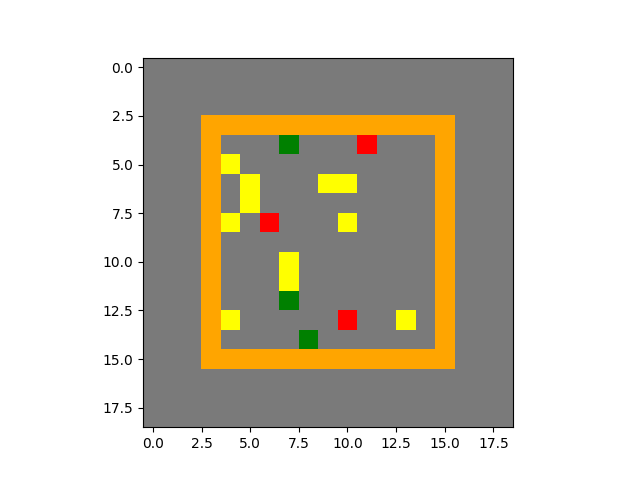

MovieWriter ffmpeg unavailable; using Pillow instead.


In [20]:
%matplotlib notebook

fig, ax = plt.subplots()

ims = []
for frame in frames:
    im = ax.imshow(frame, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True,
                                repeat=False)

ani.save("movie.gif")
plt.show()

In [11]:
# mock frames - skip unless testing
frames_3d = [
    [
        [[1,2, 2],[3,4, 4]],
        [[5,6, 6], [7,8, 8]]
    ], 
    
    [
        [[10,20, 20],[30,40, 40]],
        [[50,60, 60], [70,80, 80]]
    ], 
            ]
frames_3d = np.array(frames_3d)

In [139]:
objects = [
    [[1,0],[2,0]],
    [[1,0],[0,2]],
    [[1,2],[0,0]],
    [[1,2],[0,1]],
]
objects = np.array(objects)
signals = [
    [[10,10],
     [10,20]],
    [[15,-10],
     [20,20]],
    [[10,20],
     [-2,2]],
    [[20,2],
     [20,10]],
]
signals = np.array(signals)
# TODO read color map
color_map = {0: 'black', 1: 'blue', 2: 'red'}

def normalize_signals(signals, objects):
    signals = (signals - np.amin(signals))
    signals = signals/np.amax(signals)
    return np.where(objects == 0, signals, 0)
    
def to_objects_and_signals(frames_3d):
    objects = frames_3d[:, :, :, 0]
    signals_3d = frames_3d[:,:,:, 1:]
    signals_sum = np.sum(signals_3d, axis=3)
    signals_norm = normalize_signals(signals_sum, objects)
    return objects, signals_norm

def get_object_color(x, color_map):
    color_name = color_map[x]
    return colors.to_rgb(color_name)
    
def objects_to_colors(objects, color_map):
    shape = objects.shape
    objects_rgb = [get_object_color(obj, color_map) for obj in objects.flatten()]
    return np.array(objects_rgb).reshape(*shape, -1)

def signals_to_colors(signals):
    shape = signals.shape
    signals_rgb = [np.array(colors.to_rgb('white'))*signal for signal in signals.flatten()]
    return np.array(signals_rgb).reshape(*shape, -1)

def grids_to_frames(grids):
    objects, signals = to_objects_and_signals(grids)
    objects_rgb = objects_to_colors(objects, color_map)
    signals_rgb = signals_to_colors(signals)
    objects_rgb+signals_rgb
    
# def combine(objects, signals):
#     (frames, rows, columns, _colors_dim) = objects.shape
#     combined = objects
#     for frame in range(frames):
#         for row in range(rows):
#             for col in range(columns):
#                 if not np.any(objects[frame,row, col]):
#                     combined[frame,row,col] = signals[frame,row,col]
#     combined
        
#     return np.where()
    
o = objects_to_colors(objects, color_map)
signals = normalize_signals(signals,objects)
s = signals_to_colors(signals)
s+o

array([[[[0.        , 0.        , 1.        ],
         [0.66666667, 0.66666667, 0.66666667]],

        [[1.        , 0.        , 0.        ],
         [1.        , 1.        , 1.        ]]],


       [[[0.        , 0.        , 1.        ],
         [0.        , 0.        , 0.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 0.        , 0.        ]]],


       [[[0.        , 0.        , 1.        ],
         [1.        , 0.        , 0.        ]],

        [[0.26666667, 0.26666667, 0.26666667],
         [0.4       , 0.4       , 0.4       ]]],


       [[[0.        , 0.        , 1.        ],
         [1.        , 0.        , 0.        ]],

        [[1.        , 1.        , 1.        ],
         [0.        , 0.        , 1.        ]]]])